# How to train
Run every cell as usual.
Got best results on toy with 15 epochs

# 1 Setup

## 1.1 Download Data

In [32]:
import json

api_token = {"username":"bustin1","key":"914b2f1eda974e0940999f8187a85285"}

!mkdir .kaggle
!mkdir ~/.kaggle

with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [33]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle --version

  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
Kaggle API 1.5.12


In [34]:
# download data
!kaggle competitions download -c 11785-fall2021-hw4p2

11785-fall2021-hw4p2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [35]:
!mkdir data

!unzip -qo './11785-fall2021-hw4p2.zip' -d data 

mkdir: cannot create directory ‘data’: File exists


## 1.2 Libraries

In [36]:
!pip install python-Levenshtein

In [37]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm.notebook import trange, tqdm
import random
from torch.utils import data
import Levenshtein

cuda = torch.cuda.is_available()
print(cuda, sys.version)
device = torch.device("cuda" if cuda else "cpu")
# np.random.seed(420)
# torch.manual_seed(420)

LETTER_LIST = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 
               'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', ' ', '<eos>']

True 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


# 2 Dataloaders/Datasets

## 2.1 helpers

In [38]:
from typing import List, Tuple, Dict

def create_dictionaries(letter_list: List[str]) -> Tuple[Dict[str, int], Dict[int, str]]:
    '''
    Create dictionaries for letter2index and index2letter transformations
    '''
    letter2index = {letter : index for index,letter in enumerate(LETTER_LIST)}
    index2letter = letter_list
    return letter2index, index2letter
    
def transform_letter_to_index(raw_transcripts: List[str]) -> List[int]:
    '''
    Transforms text input to numerical input by converting each letter 
    to its corresponding index from letter_list

    Args:
        raw_transcripts: Raw text transcripts with the shape of (N, )
    
    Return:
        transcripts: Converted index-format transcripts. This would be a list with a length of N
    '''
    transforms = []
    for phrase in raw_transcripts:
        # transforms.append([letter2index["<sos>"]])
        transforms.append([])
        for letter in phrase:
            transforms[-1].append(letter2index[letter])
        transforms[-1].append(letter2index['<eos>'])
    return transforms

letter2index, index2letter = create_dictionaries(LETTER_LIST)

##2.2 Toy

In [39]:
train_data = np.load('data/hw4p2_toy_dataset/hw4p2_toy_dataset/train.npz', allow_pickle=True, encoding='bytes')['data']
valid_data = np.load('data/hw4p2_toy_dataset/hw4p2_toy_dataset/dev.npz', allow_pickle=True, encoding='bytes')['data']

raw_train_transcript = np.load('data/hw4p2_toy_dataset/hw4p2_toy_dataset/train_transcripts.npz', allow_pickle=True,encoding='bytes')
raw_valid_transcript = np.load('data/hw4p2_toy_dataset/hw4p2_toy_dataset/dev_transcripts.npz', allow_pickle=True,encoding='bytes')

train_transcript = transform_letter_to_index(raw_train_transcript['data'])
valid_transcript = transform_letter_to_index(raw_valid_transcript['data'])


##2.4 Create custom dataset

In [40]:
class MyDataset(data.Dataset):
    def __init__(self, X, Y=None):
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        if self.Y is None:
            return torch.as_tensor(self.X[index])
        else:
            return torch.as_tensor(self.X[index]), torch.as_tensor(self.Y[index], dtype=torch.long)

def collate_train_val(batch):
    """
    Return:
        pad_x: the padded x (training/validation speech data) 
        pad_y: the padded y (text labels - transcripts)
        x_len: the length of x
        y_len: the length of y
    """
    xx, yy = zip(*batch)

    x_lens = torch.tensor([len(x) for x in xx])
    y_lens = torch.tensor([len(y) for y in yy])

    xx_pad = rnn_utils.pad_sequence(xx, batch_first=True, padding_value=0) # BxLxC
    yy_pad = rnn_utils.pad_sequence(yy, batch_first=True, padding_value=0)

    return xx_pad.to(device), yy_pad.to(device), x_lens, y_lens

def collate_test(batch):
    """
    Return:
        pad_x: the padded x (testing speech data) 
        x_len: the length of x
    """

    xx = batch
    x_lens = torch.tensor([len(x) for x in xx])
    xx_pad = rnn_utils.pad_sequence(xx, batch_first=True, padding_value=0)

    return xx_pad.to(device)

In [41]:
batch_size=64

In [42]:
# Create datasets
train_dataset = MyDataset(train_data, train_transcript)
valid_dataset = MyDataset(valid_data, valid_transcript)
# test_dataset = MyDataset(test_data)

# Create data loaders
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=collate_train_val)
valid_loader = data.DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, collate_fn=collate_train_val)



# 3 Build Model

## 3.2 Encoder

In [43]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key, value and unpacked_x_len.

    '''
    def __init__(self, input_dim, encoder_hidden_dim, key_value_size=128):
        super(Encoder, self).__init__()
        # The first LSTM layer at the bottom
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=encoder_hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.key_network = nn.Linear(2 * encoder_hidden_dim, key_value_size)
        self.value_network = nn.Linear(2 * encoder_hidden_dim, key_value_size)

    def forward(self, x, x_len): # BxLxC
        packed_x = rnn_utils.pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)

        packed_x, _ = self.lstm(packed_x)
        # x = self.pBLSTMs(packed_x)
        padded_x, x_len = rnn_utils.pad_packed_sequence(packed_x, batch_first=True)

        # print(f'In encoder forward: padded_x{padded_x.shape}')
        
        key = self.key_network(padded_x)
        value = self.value_network(padded_x)
        
        return key, value, x_len

## 3.3 Attention

In [44]:
def plot_attention(attention):
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, query, key, value, mask):
        """
        input:
            key: (batch_size, seq_len, d_k)
            value: (batch_size, seq_len, d_v)
            query: (batch_size, d_q)
        * Hint: d_k == d_v == d_q is often true if you use linear projections
        return:
            context: (batch_size, key_val_dim)
        
        """
        energy = torch.bmm(key, query.unsqueeze(2)).squeeze(2) # BxL
        energy_mask = energy.masked_fill(mask == 0, -1e9) # BxL
        attention = F.softmax(energy_mask, dim=1) # BxL
        context = torch.bmm(attention.unsqueeze(1), value).squeeze(1) #BxK

        return context, attention


## 3.4 Decoder

In [45]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Decoder, self).__init__()
        # Hint: Be careful with the padding_idx
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=letter2index['<sos>'])
        # The number of cells is defined based on the paper
        self.lstm1 = nn.LSTMCell(embed_dim + key_value_size, decoder_hidden_dim) # CONCAT input with context
        self.lstm2 = nn.LSTMCell(decoder_hidden_dim, key_value_size)
    
        self.attention = Attention()

        self.vocab_size = vocab_size
        self.character_prob = nn.Linear(2*key_value_size, vocab_size) #: d_v -> vocab_size
        self.key_value_size = key_value_size
        
        # Weight tying
        self.character_prob.weight = self.embedding.weight

    def forward(self, key, value, encoder_len, y=None, y_lens=None, mode='train', tf_rate=.9):
        B, key_seq_max_len, key_value_size = key.shape
        if mode == 'train':
            max_len =  y.shape[1]
            char_embeddings = self.embedding(y) # BxLxEmbedding Size
        else:
            max_len = 600

        mask = torch.arange(key_seq_max_len).repeat(B,1) < encoder_len.unsqueeze(1) # BxL
        mask = mask.to(device)
        
        predictions = []
        prediction = None
        hidden_states = [None, None] 
        
        context = torch.zeros((B,key_value_size), device=device) # fill this out

        attention_plot = [] # this is for debugging
        sos = torch.full((B,), fill_value=letter2index['<sos>'], device=device)

        for i in range(max_len):

            if mode == 'train':
                if np.random.random() <= tf_rate: 
                    if i == 0:
                        char_embed = self.embedding(sos)
                    else:
                        char_embed = char_embeddings[:,i-1,:]
                else:
                    if i == 0:
                        char_embed = self.embedding(sos)
                    else:
                        char_embed = self.embedding(prediction.argmax(dim=1))
            else:
                if i == 0:
                    char_embed = self.embedding(sos)
                else:
                    char_embed = self.embedding(prediction.argmax(dim=1))

            y_context = torch.cat([char_embed, context], dim=1)
            hidden_states[0] = self.lstm1(y_context, hidden_states[0])

            hidden_states[1] = self.lstm2(hidden_states[0][0], hidden_states[1])
            query = hidden_states[1][0]
            
            context, attention = self.attention(query, key, value, mask)
            attention_plot.append(attention[0].detach().cpu())
            
            output_context = torch.cat([context, query], dim=1) # context is BxKEY value size, query is same
            prediction = self.character_prob(output_context) #BxVOCAB_SIZE
            predictions.append(prediction.unsqueeze(1))
        
        attentions = torch.stack(attention_plot, dim=0)
        predictions = torch.cat(predictions, dim=1) # BxLxNum of Classes

        # B*VOCAB_SIZE
        
        return predictions, attentions

## 3.5 Seq To Seq

In [46]:
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, vocab_size, encoder_hidden_dim, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Seq2Seq,self).__init__()
        self.encoder = Encoder(input_dim=input_dim, encoder_hidden_dim=encoder_hidden_dim, key_value_size=key_value_size)
        self.decoder = Decoder(vocab_size=vocab_size, decoder_hidden_dim=decoder_hidden_dim, embed_dim=embed_dim, key_value_size=key_value_size)

    def forward(self, x, x_len, y=None, y_lens=None, mode='train', tf_rate=.95):
        key, value, encoder_len = self.encoder(x, x_len)
        predictions, attentions = self.decoder(key, value, encoder_len, y=y, y_lens=y_lens, mode=mode, tf_rate=tf_rate)
        return predictions, attentions

# 4 Train

## 4.1 Build Model

In [47]:
model = Seq2Seq(input_dim=40, vocab_size=len(LETTER_LIST), encoder_hidden_dim=512, decoder_hidden_dim=512, embed_dim=256)
model.to(device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(40, 512, batch_first=True, bidirectional=True)
    (key_network): Linear(in_features=1024, out_features=128, bias=True)
    (value_network): Linear(in_features=1024, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(34, 256, padding_idx=0)
    (lstm1): LSTMCell(384, 512)
    (lstm2): LSTMCell(512, 128)
    (attention): Attention()
    (character_prob): Linear(in_features=256, out_features=34, bias=True)
  )
)


### HyperParameters

In [48]:
n_epochs = 15
optimizer = optim.Adam(model.parameters(), lr=.001)
criterion = nn.CrossEntropyLoss(reduction='none')


##4.2 Train loop

In [49]:
def train(model, train_loader, criterion, optimizer, mode):
    model.train()
    running_loss = 0
    mode = 'train'
    max_iter = len(train_loader)

    with tqdm(total=max_iter) as pbar:
      for i, batch in enumerate(train_loader):
          xx, yy, x_lens, y_lens = batch

          predictions, attentions = model(xx, x_lens, yy, y_lens, mode=mode)
    
          B = predictions.size(0)
          L = predictions.size(1)
          C = predictions.size(2)
          mask = torch.arange(L).repeat(B, 1) < y_lens.unsqueeze(1) # BxL
          mask = mask.to(device)
        
          loss = criterion(predictions.reshape(-1, C), yy.reshape(-1)) # B*L shape. The +1 is there to prevent sos  
          masked_loss = torch.sum(loss * (mask.reshape(-1))) / torch.sum(y_lens)
          running_loss += masked_loss

          optimizer.zero_grad()   
          masked_loss.backward()
          utils.clip_grad_norm(model.parameters(), 2)
          optimizer.step()

          pbar.update()
          pbar.set_description(f"(# {i+1}/{max_iter}) avg loss: {running_loss / (i+1)}")
          if i % 20 == 0:
              plot_attention(attentions)

## 4.3 Val Loop

In [50]:
def val(model, valid_loader, mode):
    model.eval()
    running_loss = 0
    max_iter = len(valid_loader)
    leven_dist = 0

    with torch.no_grad():
        with tqdm(total=max_iter) as pbar:
            for i, batch in enumerate(valid_loader):
                xx, yy, x_lens, y_lens = batch

                predictions, attentions = model(xx, x_lens, yy, mode=mode)

                B = predictions.size(0)
                L = predictions.size(1)
                C = predictions.size(2)
                mask = torch.arange(L).repeat(B, 1) < y_lens.unsqueeze(1) # BxL
                mask = mask.to(device)

                loss = criterion(predictions.reshape(-1, C), yy.reshape(-1)) # B*L shape

                masked_loss = torch.sum(loss * (mask.reshape(-1))) / torch.sum(y_lens)
                running_loss += masked_loss

                pbar.update()
                pbar.set_description(f"(# {i}/{max_iter}) avg loss: {running_loss / (i+1)}")

## 4.4 Run Epochs

  0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


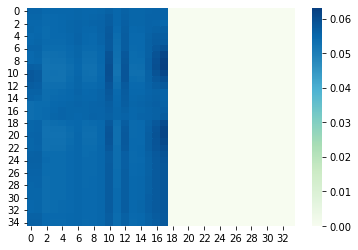

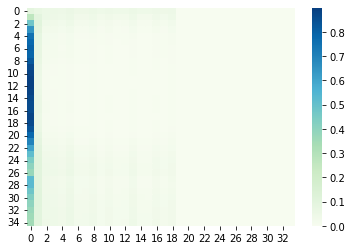

KeyboardInterrupt: ignored

In [51]:
for epoch in range(n_epochs):
    train(model, train_loader, criterion, optimizer, mode='train')
    val(model, valid_loader, mode='train')
    print(f'On Epoch [{epoch+1}/{n_epochs}]')

# Final Answer (PLEASE WORK PLEASE WORK IM TIRED PLEASE WORK)

[29, 21, 21, 31, 26, 31, 20, 18, 34, 15]
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 2

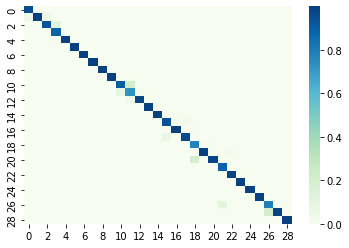

torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 2

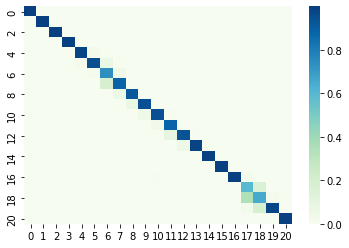

torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 2

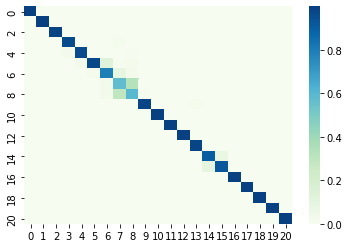

torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 2

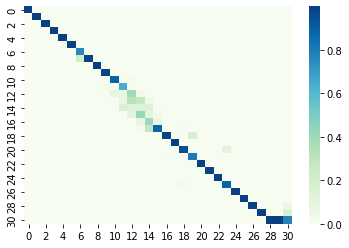

torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 2

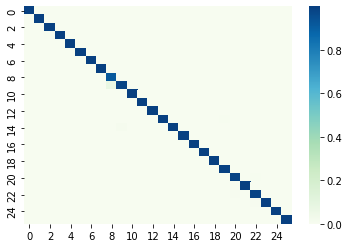

torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 2

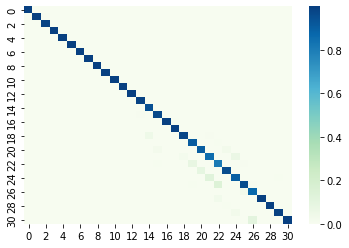

torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 2

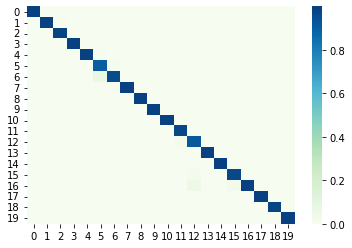

torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 2

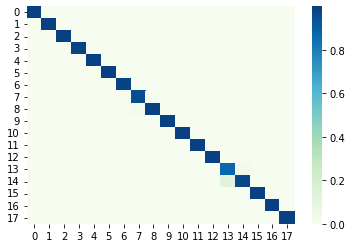

torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 2

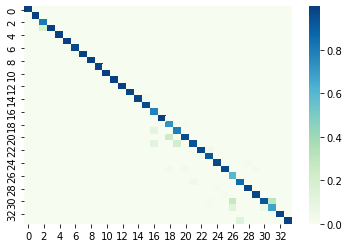

torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 256])
torch.Size([1, 34])
torch.Size([1, 2

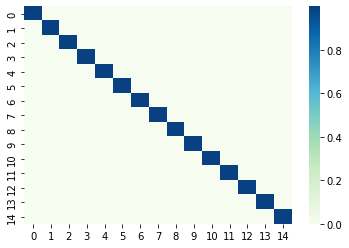

In [27]:
valid_loader = data.DataLoader(valid_dataset, shuffle=False, batch_size=1, collate_fn=collate_train_val)
val_label_lengths = [len(x) for x in valid_data[:10]]
print(val_label_lengths)
ans = []
with torch.no_grad():
    for i, batch in enumerate(valid_loader):
        xx, yy, x_lens, y_lens = batch

        predictions, attentions = model(xx, x_lens, yy, mode='valid')
        ans.append(attentions.T[:, :x_lens[0]])
        plot_attention(ans[-1])
        
        if i == 9:
            break

In [28]:
outfile = 'attention.npy'
np.save(outfile, np.array([np.array(x) for x in ans]))
# np.array([np.array(x) for x in ans]).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
